In [35]:
import torch.nn as nn 
# import torch.nn.functional as F
import numpy as np
import torch
import matplotlib.pyplot as plt

In [36]:
# to run

import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
import os
import torchvision



IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)

    return images

def get_transform():
    transform_list = []
    transform_list += [transforms.Resize([360, 640], Image.BICUBIC),
#         transforms.Resize([256,256]),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

class CreateDataset(data.Dataset):
    def __init__(self):
        super(CreateDataset, self).__init__()
        
        dataroot = 'images/'
        phase='train/' # train for training and test for testing
        self.dir_A = os.path.join(dataroot, phase , 'A') # directory for blur images
        self.dir_B = os.path.join(dataroot, phase , 'B') # directory for sharp images
        self.A_paths = make_dataset(self.dir_A) # get paths of all blurred images 
        self.B_paths = make_dataset(self.dir_B) # get paths of all blurred images
        self.A_paths = sorted(self.A_paths) # sort the images because all the related images are together
        self.B_paths = sorted(self.B_paths)
        self.A_size = len(self.A_paths) # 2103 images in A and B each
        self.B_size = len(self.B_paths)
        self.transform = get_transform() # apply transforms
#         print(self.transform)
        
    def name(self):
        return 'BaseDataset'
    
    def __getitem__(self, index): # not used
        A_path = self.A_paths[index % self.A_size]
        index_A = index % self.A_size
        B_path = self.B_paths[index % self.A_size]
        index_B = index % self.B_size
#        print('(A, B) = (%d, %d)' % (index_A, index_B))
        A_img = Image.open(A_path).convert('RGB')
        B_img = Image.open(B_path).convert('RGB')
        
        A_img = self.transform(A_img)
        B_img = self.transform(B_img)
        return {'A': A_img, 'B': B_img,
                'A_paths': A_path, 'B_paths': B_path}

    def __len__(self):
        return max(self.A_size, self.B_size)

class CreateDataLoader():
    def name(self):
        return 'CreateDataLoader'

    def __init__(self):
        super(CreateDataLoader,self).__init__()
        batchSize = 4
        self.dataset = CreateDataset() # Call to create dataset class
        self.dataloader = data.DataLoader(
            self.dataset,
            batch_size = batchSize,
            shuffle = False
        )

    def load_data(self):
        return self.dataloader

    def __len__(self):
        return len(self.dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


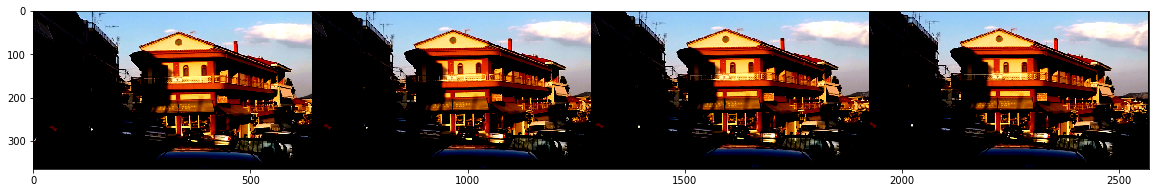

In [37]:
# not to run
# to check if data is loaded

# data_loader = CreateDataLoader()
# dataset = data_loader.load_data()

# def imshow(img):
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# for i, data in enumerate(dataset):
# # show images
#     if i==0:
#         fig = plt.figure(figsize=(20, 15))
#         imshow(torchvision.utils.make_grid(data['A']))
#         imshow(torchvision.utils.make_grid(data['B']))
#     else:
#         break

# Discriminator Architecture

In [38]:
class Discriminator(nn.Module):   
    """Defines a PatchGAN discriminator"""
    def __init__(self, input_nc = 3, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False,
                 use_parallel=True):  
        super(Discriminator, self).__init__()
        
        """
         Parameters:
            input_nc (int)  -- the number of channels in input images. For color images this is 3.
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer (can be nn.BatchNorm2d or nn.InstanceNorm2d)
        """
        
#         ndf = 64
#         output_nc = 3
#         input_shape_discriminator = (256, 256, output_nc)    
#         n_layers = 3
#         use_sigmoid = False
#         gpu_ids = []
#         norm_layer = nn.BatchNorm2d
#         ndf = 64
#         input_nc = 3
#         use_parallel = True

        kw = 4 # kernel size
        padw = int(np.ceil((kw - 1) / 2)) # 2

        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]
        
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers): # runs for 2 iterations
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8) # n_layers = 3
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw), # default bias value is True
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
        # output image till here is 32 * 32 * 256
        
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8) 
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
        
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)
        
    def forward(self, input):
#         if len(self.gpu_ids) and isinstance(input.data, torch.cuda.FloatTensor) and self.use_parallel:
#             return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
#         else:
            return self.model(input)

In [45]:
# defining the model
model = Discriminator()
model

pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

2766529

# Generator Architecture

In [40]:
class Generator(nn.Module):   
    """Defines a RESNET Generator"""
    def __init__(self, input_nc = 3, ngf = 64, n_layers=3, norm_layer=nn.BatchNorm2d, use_dropout=True, 
                 n_blocks = 9, learn_residual = True,
                 use_parallel=True, padding_type='reflect'):
        assert (n_blocks >= 0)
        super(Generator, self).__init__()
        
#         use_gpu = len(gpu_ids) > 0
        
#         if use_gpu:
#             assert (torch.cuda.is_available())
        
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
            norm_layer(ngf),
            nn.ReLU(True)
        ]
        
        n_downsampling = 2
        
        # Increase filter number
        model += [
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            norm_layer(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            norm_layer(256),
            nn.ReLU(True)
        ]
        
        # Apply 9 ResNet blocks
        for i in range(n_blocks):
            model += [
                ResnetBlock(256, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout)
            ]
          
        # Decrease filter number to 3 (RGB)
        model += [
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            norm_layer(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            norm_layer(64),
            nn.ReLU(True),
        ]
        
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels = 3 , kernel_size=7, padding=0),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
        
    def forward(self, input):
#         if self.gpu_ids and isinstance(input.data, torch.cuda.FloatTensor) and self.use_parallel:
#             output = nn.parallel.data_parallel(self.model, input, self.gpu_ids)
#         else:
        output = self.model(input)
        
        # Add direct connection from input to output and recenter to [-1, 1]
        if self.learn_residual:
            # output = input + output
#             https://pytorch.org/docs/stable/torch.html#torch.clamp
            output = torch.clamp(input + output, min=-1, max=1)
        return output

In [41]:
class ResnetBlock(nn.Module):
    """RESNET Block"""
    
    """
    Parameters:
    Instantiate a PyTorch Resnet Block using Sequential API.
        input: Input tensor
        filters: Number of filters to use
        kernel_size: Shape of the kernel for the convolution
        strides: Shape of the strides for the convolution
        use_dropout: Boolean value to determine the use of dropout
        return: Pytorch Model
    """
    def __init__(self, dim, padding_type, norm_layer, use_dropout):
        super(ResnetBlock, self).__init__()
        
        blocks = [ 
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            norm_layer(dim),
            nn.ReLU(True)
        ]
        
        if use_dropout:
            blocks += [
                nn.Dropout(0.5)
            ]
        
        blocks += [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            norm_layer(dim)
        ]
            
        self.conv_block = nn.Sequential(*blocks)
    
    def forward(self, x):
        # Two convolution layers followed by a direct connection between input and output
            out = x + self.conv_block(x)
            return out

In [44]:
model = Generator()
model
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

11388675

# Perceptual Loss

In [43]:
import torchvision.models as models

class PerceptualLoss():
    def contentFunc(self):
        conv_3_3_layer = 14
        cnn = models.vgg19(pretrained=True).features
        cnn = cnn.cuda()
        model = nn.Sequential()
        model = model.cuda()
        for i, layer in enumerate(list(cnn)):
            model.add_module(str(i), layer)
            if i == conv_3_3_layer:
                break
        return model

    def __init__(self, loss):
        self.criterion = loss
        self.contentFunc = self.contentFunc()

    def get_loss(self, fakeIm, realIm):
        f_fake = self.contentFunc.forward(fakeIm)
        f_real = self.contentFunc.forward(realIm)
        f_real_no_grad = f_real.detach()
        loss = self.criterion(f_fake, f_real_no_grad)
        return loss

In [10]:
content_loss = PerceptualLoss(nn.MSELoss())

In [11]:
content_loss

In [12]:
# class DiscLossWGANGP(DiscLossLS):
#     def name(self):
#         return 'DiscLossWGAN-GP'

#     def __init__(self, opt, tensor):
#         super(DiscLossWGANGP, self).__init__(opt, tensor)
#         # DiscLossLS.initialize(self, opt, tensor)
#         self.LAMBDA = 10

#     def get_g_loss(self, net, realA, fakeB):
#         # First, G(A) should fake the discriminator
#         self.D_fake = net.forward(fakeB)
#         return -self.D_fake.mean()

#     def calc_gradient_penalty(self, netD, real_data, fake_data):
#         alpha = torch.rand(1, 1)
#         alpha = alpha.expand(real_data.size())
#         alpha = alpha.cuda()

#         interpolates = alpha * real_data + ((1 - alpha) * fake_data)

#         interpolates = interpolates.cuda()
#         interpolates = Variable(interpolates, requires_grad=True)

#         disc_interpolates = netD.forward(interpolates)

#         gradients = autograd.grad(
#             outputs=disc_interpolates, inputs=interpolates, grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
#             create_graph=True, retain_graph=True, only_inputs=True
#         )[0]

#         gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.LAMBDA
#         return gradient_penalty

In [13]:
# copied from dhruva

from torchvision import models

def init_loss(tensor):
    # disc_loss = None
    # content_loss = None
    
    content_loss = PerceptualLoss(nn.MSELoss())
    # content_loss.initialize(nn.MSELoss())

    disc_loss = DiscLoss(tensor)

    return disc_loss, content_loss

def real_mse_loss(y_true, y_pred):
    # how close is the produced output from being "real"?
    criterion = torch.nn.MSELoss()
    # calculate loss
    loss = criterion(y_pred,y_true)
    return loss
    #return torch.mean((D_out-1)**2)

def fake_mse_loss(y_true, y_pred):
    # how close is the produced output from being "fake"?
    criterion = torch.nn.MSELoss()
    # calculate loss
    loss = criterion(y_pred,y_true)
    return loss
    #return torch.mean(D_out**2)

def perceptual_loss(y_true, y_pred):
    cnn = models.vgg19(pretrained=True).features
    cnn = cnn.cuda()
    model = nn.Sequential()
    model = model.cuda()
    for i,layer in enumerate(list(cnn)):
        model.add_module(str(i),layer)
        if i == 'conv_3_3_layer':
            break
    return torch.mean((y_true-y_pred)**2)

class PerceptualLoss():
    def contentFunc(self):
        conv_3_3_layer = 14
        cnn = models.vgg19(pretrained=True).features
        cnn = cnn.cuda()
        model = nn.Sequential()
        model = model.cuda()
        for i, layer in enumerate(list(cnn)):
            model.add_module(str(i), layer)
            if i == conv_3_3_layer:
                break
        return model

    def __init__(self, loss):
        self.criterion = loss
        self.contentFunc = self.contentFunc()

    def get_loss(self, fakeIm, realIm):
        f_fake = self.contentFunc.forward(fakeIm)
        f_real = self.contentFunc.forward(realIm)
        f_real_no_grad = f_real.detach()
        loss = self.criterion(f_fake, f_real_no_grad)
        return loss
    
class DiscLoss:
    def name(self):
        return 'DiscLoss'

    def __init__(self, loss):
        self.criterion = torch.nn.MSELoss()
        

    def get_g_loss(self,net, realA, fakeB):
        # First, G(A) should fake the discriminator
        pred_fake = net.forward(fakeB)
        return self.criterion(pred_fake, 1)

    def get_loss(self, net, realA, fakeB, realB):
        # Fake
        # stop backprop to the generator by detaching fake_B
        # Generated Image Disc Output should be close to zero
        self.pred_fake = net.forward(fakeB.detach())
        self.loss_D_fake = self.criterionGAN(self.pred_fake, 0)

        # Real
        self.pred_real = net.forward(realB)
        self.loss_D_real = self.criterionGAN(self.pred_real, 1)

        # Combined loss
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        return self.loss_D
    
def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true*y_pred)

In [14]:
import torch.optim as optim

G = Generator()
D = Discriminator()
#Gen_Dis(G,D)
    
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    G.to(device)
    D.to(device)
 #   G_D.to(device)
    print('Models moved to GPU.')
else:
    print('Only CPU available.')

        
# hyperparams for Adam optimizer
lr=1E-4
beta1=0.9
beta2=0.999 # default value

# Create optimizers for the generators and discriminators
optimizer_G = torch.optim.Adam( G.parameters(), lr=lr, betas=(beta1, beta2) )
optimizer_D = torch.optim.Adam( D.parameters(), lr=lr, betas=(beta1, beta2) )
#optimizer_G_D = torch.optim.Adam( G_D.parameters(), lr=lr, betas=(beta1, beta2) )

Models moved to GPU.


In [33]:
from torch import FloatTensor as Tensor

def training_loop(n_epochs=100):
    
    data_loader=CreateDataLoader()
    dataset = data_loader.load_data()
    print_every=10
    valid_loss_min = np.Inf 
    
    batch_size = 4
    # keep track of losses over time
    losses = []
    

    # the "_" is a placeholder for no labels

    # batches per epoch

    
    
    for epoch in range(1, n_epochs+1):
        
        for i, data in enumerate(dataset):
            D.train()
            G.train()
            
            images_X=data['A']
            images_Y=data['B']
   
            # move images to GPU if available (otherwise stay on CPU)
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            real_X = images_X.to(device)
            real_Y = images_Y.to(device)


            # ============================================
            #            TRAIN THE DISCRIMINATORS
            # ============================================
            
            
            # 2. Generate fake images that look like domain X based on real images in domain Y
            
            fake_Y = G(real_X)
            
            ##   First: D_X, real and fake loss components   ##

            # Train with real images
            optimizer_D.zero_grad()

            # 1. Compute the discriminator losses on real images
            out_x = D(real_Y)
            output_true_batch, output_false_batch = Tensor(out_x.size()).fill_(1), Tensor(out_x.size()).fill_(-1)
            output_true_batch = output_true_batch.to(device)
            output_false_batch = output_false_batch.to(device)
        
            D_X_real_loss = real_mse_loss(out_x,output_true_batch)

            # Train with fake images

            
            # 3. Compute the fake loss for D_X
            out_x = D(fake_Y)
        
            D_X_fake_loss = fake_mse_loss(out_x,output_false_batch)


            # 4. Compute the total loss and perform backprop
            d_x_loss = (D_X_real_loss+D_X_fake_loss)/2
            d_x_loss.backward(retain_graph=True)
            optimizer_D.step()



            # =========================================
            #            TRAIN THE GENERATORS
            # =========================================

            ##    First: generate fake X images and reconstructed Y images    ##
            optimizer_G.zero_grad()


            # 1. Generate fake images that look like domain X based on real images in domain Y
           # fake_X = G(images_X)

            # 2. Compute the generator loss based on domain X
            out_x = D(fake_Y)
     
            g_loss = real_mse_loss(out_x,output_true_batch)

            g_loss.backward()
            optimizer_G.step()


            # Print the log info
            if epoch % print_every == 0:
                # append real and fake discriminator losses and the generator loss
                losses.append((d_x_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f}  | g_total_loss: {:6.4f}'.format(
                        epoch, n_epochs, d_x_loss.item(), g_loss.item()))


            sample_every=10000
            # Save the generated samples
            if epoch % sample_every == 0:
                G.eval() # eval mode for generating samples
                save_samples(epoch, fixed_Y, fixed_X, G , batch_size=2)
                G.train()

            if d_x_loss <= valid_loss_min:
                torch.save(G.state_dict(), 'model_G.pt')
                torch.save(D.state_dict(), 'model_D.pt')
                valid_loss_min = d_x_loss

            # uncomment these lines, if you want to save your model
            checkpoint_every=1000
            # Save the model parameters
            if epoch % checkpoint_every == 0:
                checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses

In [34]:
losses = training_loop(n_epochs=10)

RuntimeError: CUDA out of memory. Tried to allocate 58.00 MiB (GPU 0; 4.00 GiB total capacity; 2.96 GiB already allocated; 780.80 KiB free; 3.04 GiB reserved in total by PyTorch)